In [27]:
using JuMP, CPLEX, LinearAlgebra, DelimitedFiles, Plots, LinA

mc = readdlm("mcSmashWiki.csv", ';', Float64)
mc= round.(mc, digits=2)
usage = [readdlm("communityDistribution.csv", ',', Float64)...]


In [43]:
#Basic Model

model = Model(CPLEX.Optimizer)
MOI.set(model, MOI.Silent(), true)
@variable model x[1:26] >= 0

@objective model Max x'*mc*usage
@constraint model sum(x) == 1
optimize!(model)
println(value.(x)')

objective_value(model)

[0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


0.5598356589391458

In [101]:
model = Model(CPLEX.Optimizer)
MOI.set(model, MOI.Silent(), true)
@variable model x[1:26] >= 0

σ(x) = 1 /(1 +exp(-5x))
learningRate(x) = 2σ(x)-1
lrLin = Linearize(learningRate,0,1,Absolute(0.01))
nbpiece=length(lrLin)

@variable model active[1:26,1:nbpiece] binary = true
@variable model f[1:26,1:nbpiece] >= 0

#only one piece has weight
for i in 1:26
    @constraint model sum(active[i,:]) <= 1
end

#binding piece with activation
for i=1:26,j=1:nbpiece
    @constraint model f[i,j] - lrLin[j].xMin*active[i,j] >= 0
    @constraint model f[i,j] - lrLin[j].xMax*active[i,j] <= 0
end

#constraint probability distribution

@constraint model sum(f) == 1

#function to optimize
α = 0
for i=1:26,j=1:nbpiece    
    α += (mc*usage)[i]*(lrLin[j].a*f[i,j] + lrLin[j].b*active[i,j])
end

@objective model Max α

optimize!(model)

playrates = sum(value.(f),dims=2)

26×1 Array{Float64,2}:
 0.0
 0.0
 0.22723261660601585
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0910695335759365
 0.0
 0.0
 0.0
 0.0
 0.0
 0.22723261660601585
 0.0
 0.0
 0.0
 0.22723261660601585
 0.22723261660601585
 0.0
 0.0
 0.0
 0.0
 0.0

In [94]:
playrates'mc*usage

1-element Array{Float64,1}:
 0.5232302370966638

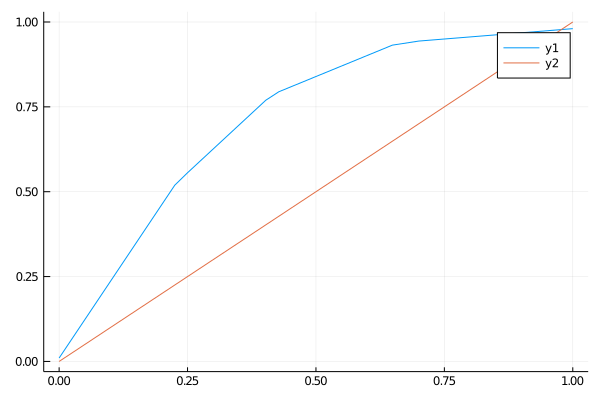

In [99]:
plot([x->lrLin(x) x->x],0,1)

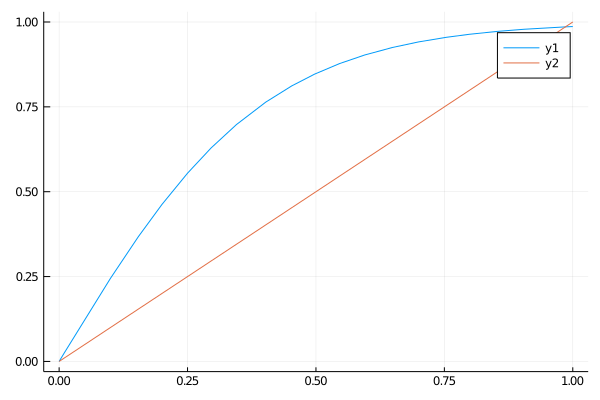

In [102]:
plot([learningRate x->x],0,1)